In [25]:
using Pkg
Pkg.activate(".")  # crea/usa un Project.toml local al notebook
Pkg.add([
    "CSV","XLSX","DataFrames", "CategoricalArrays", "StatsModels", "GLM",
    "MLJ", "MLJLinearModels", "Lasso", "GLMNet", "Statistics", "Random", "LinearAlgebra"
])

using CSV, DataFrames, CategoricalArrays, StatsModels, GLM
using XLSX
using MLJ
using Lasso, GLMNet
using Statistics, Random, LinearAlgebra


  Activating project at `c:\Users\diego\OneDrive\Documents\GitHub\Lasso_Potential_Outcomes_RCTs\Julia\scripts`
   Resolving package versions...
  No Changes to `C:\Users\diego\OneDrive\Documents\GitHub\Lasso_Potential_Outcomes_RCTs\Julia\scripts\Project.toml`
  No Changes to `C:\Users\diego\OneDrive\Documents\GitHub\Lasso_Potential_Outcomes_RCTs\Julia\scripts\Manifest.toml`


In [ ]:
using XLSX, DataFrames

function load_and_clean(path::AbstractString; sheet::Union{Nothing,String}=nothing)
    xf = XLSX.readxlsx(path)                                   
    shname = isnothing(sheet) ? first(XLSX.sheetnames(xf)) : sheet
    sh = xf[shname]                                            

    A = sh[:]                                                  
    headers = Symbol.(string.(A[1, :]))                        
    df = DataFrame(A[2:end, :], headers)                       
    dropmissing!(df)                                           
    return df
end


load_and_clean (generic function with 1 method)

### Asignemnt 2


### Lasso (8 points)

In [27]:
df = load_and_clean(raw"C:\Users\diego\OneDrive\Documents\GitHub\Lasso_Potential_Outcomes_RCTs\Julia\input\Districtwise_literacy_rates.xlsx"; sheet="2015_16_Districtwise")


Row,STATCD,DISTCD,STATNAME,DISTNAME,DISTRICTS,BLOCKS,VILLAGES,TOTPOPULAT,P_URB_POP,POPULATION_0_6,GROWTHRATE,SEXRATIO,P_SC_POP,P_ST_POP,OVERALL_LI,FEMALE_LIT,MALE_LIT,AREA_SQKM,TOT_6_10_15,TOT_11_13_15,SCH1,SCH2,SCH3,SCH4,SCH5,SCH6,SCH7,SCH9,SCHTOT,SCH1G,SCH2G,SCH3G,SCH4G,SCH5G,SCH6G,SCH7G,SCH9G,SCHTOTG,SCH1P,SCH2P,SCH3P,SCH4P,SCH5P,SCH6P,SCH7P,SCH9P,SCHTOTP,SCH1GR,SCH2GR,SCH3GR,SCH4GR,SCH5GR,SCH6GR,SCH7GR,SCH9GR,SCHTOTGR,SCH1PR,SCH2PR,SCH3PR,SCH4PR,SCH5PR,SCH6PR,SCH7PR,SCH9PR,SELE1,SELE2,SELE3,SELE4,SELE5,SELE6,SELE7,SCOMP1,SCOMP2,SCOMP3,SCOMP4,SCOMP5,SCOMP6,SCOMP7,ENR501,ENR502,ENR503,ENR504,ENR505,ENR506,ENR507,ENR509,CLS1,CLS2,CLS3,CLS4,CLS5,CLS6,CLS7,TCH1,TCH2,TCH3,TCH4,TCH5,TCH6,TCH7
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,1,101,JAMMU & KASHMIR,KUPWARA,1,13,391,875564,11.33,1.97002e5,34.62,843,0.12,8.08,66.92,54.79,77.1,2379,135672,72701,1107,818,2,14,2,84,49,0,2076,980,697,1,14,2,49,49,0,1792,127,121,1,0,0,35,0,0,284,954,681,1,14,2,48,49,0,1749,117,114,0,0,0,23,0,0,44,69,2,8,1,40,25,23,92,1,1,1,39,16,933,237,1,13,1,8,27,43,3489,5315,27,62,23,852,239,2708,5205,43,70,28,1065,638
2,1,102,JAMMU & KASHMIR,BARAMULA,1,18,678,1015503,17.19,1.61871e5,20.34,873,0.15,3.74,66.93,55.01,77.35,4243,117874,70952,1215,825,9,11,5,176,69,0,2310,1108,639,1,11,5,96,69,0,1929,107,186,8,0,0,80,0,0,381,1031,600,1,8,5,91,60,0,1796,98,160,4,0,0,58,0,0,278,330,9,7,5,132,57,24,123,7,0,4,85,26,1014,240,0,10,4,35,49,41,4127,5800,210,53,30,1665,360,2937,5873,236,60,105,2533,964
3,1,103,JAMMU & KASHMIR,SRINAGAR,1,8,94,1269751,98.73,1.55798e5,23.56,879,0.09,0.72,71.21,63.47,77.95,1979,113560,62397,258,417,36,2,0,263,9,0,985,203,209,1,2,0,65,9,0,489,55,208,35,0,0,198,0,0,496,18,6,0,0,0,6,0,0,30,4,14,0,0,0,1,0,0,96,212,36,0,0,253,8,38,209,36,0,0,213,2,227,161,3,2,0,38,7,30,817,3284,886,11,0,2873,40,828,3647,1159,14,0,4757,129
4,1,104,JAMMU & KASHMIR,BADGAM,1,13,523,735753,11.74,1.50756e5,21.18,883,0.05,3.17,57.98,46.6,68.56,1361,118477,58838,755,537,10,10,1,98,57,0,1468,697,423,1,10,1,40,57,0,1229,56,114,9,0,0,58,0,0,237,678,411,0,10,1,40,54,0,1194,55,110,8,0,0,49,0,0,70,78,10,2,1,64,25,19,100,9,3,1,68,15,654,137,0,8,0,15,38,43,2290,3837,119,45,8,1035,325,1878,3892,250,68,19,1493,716
5,1,105,JAMMU & KASHMIR,PULWAMA,1,8,359,570060,13.8,97651.3,29.18,913,0.07,4.03,65,53.81,75.41,1086,64493,30166,532,339,4,14,2,94,43,0,1028,497,233,0,14,2,23,43,0,812,35,106,4,0,0,71,0,0,216,470,215,0,13,2,23,41,0,764,27,88,0,0,0,48,0,0,29,76,4,3,2,76,35,18,89,4,1,2,69,13,501,125,0,13,1,6,35,36,1688,2584,151,67,5,1101,209,1336,2682,113,90,38,1414,506
6,1,106,JAMMU & KASHMIR,ANANTNAG,1,12,523,1070144,26.04,2.06324e5,37.48,937,0.17,10.75,64.32,54.15,74.13,3574,150600,78343,779,869,10,14,5,160,48,0,1885,691,682,2,14,5,72,48,0,1514,88,187,8,0,0,88,0,0,371,626,619,2,12,5,66,43,0,1373,77,147,4,0,0,60,0,0,52,131,10,5,5,122,43,56,172,10,1,2,90,13,696,349,0,13,3,16,39,50,2650,5862,152,60,22,1592,185,2084,6182,261,74,95,2491,597
7,1,107,JAMMU & KASHMIR,LEH (LADAKH),1,6,110,147104,42.96,11812.5,25.48,583,0.37,71.81,80.48,64.52,89.39,45110,9066,5260,176,145,3,3,2,46,0,0,375,144,126,1,3,2,32,0,0,308,32,19,2,0,0,14,0,0,67,138,121,0,3,2,31,0,0,295,29,13,1,0,0,9,0,0,30,34,3,0,2,42,0,19,84,3,2,2,41,0,174,119,0,3,0,29,0,14,604,1059,45,9,17,473,0,470,1160,62,19,45,813,0
8,1,108,JAMMU & KASHMIR,KARGIL,1,7,134,143388,8.89,20404.1,20.18,775,0.01,86.89,74.49,58.05,86.73,14036,15468,8377,229,289,6,6,1,27,28,0,586,213,260,1,6,1,18,27,0,526,16,29,5,0,0,9,1,0,60,204,249,1,6,1,18,24,0,503,12,23,2,0,0,6,0,0,4,14,6,5,1,8,7,19,67,6,2,1,19,16,220,234,0,6,0,13,27,16,716,1469,69,26,3,220,99,471,1582,90,44,17,274,288
9,1,109,JAMMU & KASHMIR,DODA,1,10,38

0.25 points → Keep only the observations with no missing values

1 point → Create a histogram of the female and male literacy rate and comment briefly on its distribution.

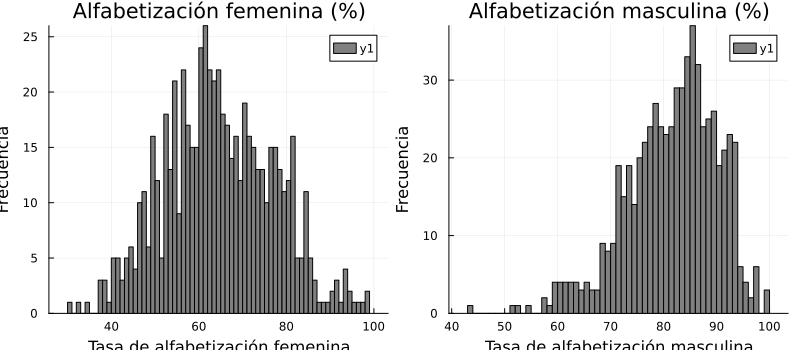

In [55]:
using Plots

# Crear subplot con 2 paneles
p1 = histogram(df.FEMALE_LIT, 
               bins=100, 
               color=:grey, 
               linecolor=:black,
               title="Alfabetización femenina (%)",
               xlabel="Tasa de alfabetización femenina",
               ylabel="Frecuencia")

p2 = histogram(df.MALE_LIT, 
               bins=100, 
               color=:grey, 
               linecolor=:black,
               title="Alfabetización masculina (%)",
               xlabel="Tasa de alfabetización masculina",
               ylabel="Frecuencia")

# Combinar los plots
plot(p1, p2, layout=(1,2), size=(800,350))

La tasa de alfabetización femenina presenta una distribución cercana a la normal, con mayor concentración en el rango del 60% al 65%. No obstante, se observa una cola izquierda más cargada, lo que indica que existen varios distritos con tasas de alfabetización femenina bajas, por otro lado, la alfabetización masculina se concentra principalmente entre el 80% y 90%, mostrando un sesgo hacia valores más altos. Esto refleja que, en promedio, los hombres alcanzan mayores niveles de alfabetización que las mujeres, evidenciando clara disparidad de género.

In [33]:
using DataFrames, Random, Distributions, GLMNet, Statistics

# ----- 2.2 Low-dimensional specification: FEMALE_LIT ~ MALE_LIT + P_URB_POP -----
target     = :FEMALE_LIT
predictors = [ :TOTPOPULAT, :P_URB_POP, :GROWTHRATE, :SEXRATIO, :AREA_SQKM,
    :SCHTOT, :SCH1, :SCH6, :SCHTOTG, :TOT_11_13_15, :SCOMP5,
    :SCH1GR, :SCH6GR, :SCH1PR, :SCH6PR,
    :ENR501, :ENR506, :ENR509,
    :TCH1, :TCH6]   # ajusta si quieres otros

# Ensure numeric Float64 types
tofloat(col) = [x isa Real ? float(x) : parse(Float64, String(x)) for x in col]
df  = dropmissing(df)
df[!, target] = tofloat(df[!, target])
for c in predictors
    df[!, c] = tofloat(df[!, c])
end

# Matrices
X = Matrix{Float64}(select(df, predictors))
y = Vector{Float64}(df[!, target])

# Train/test split without StatsBase
Random.seed!(123)
n = nrow(df)
perm = randperm(n)
ntr  = Int(round(0.7n))
train_idx = perm[1:ntr]
test_idx  = perm[ntr+1:end]

# LASSO (alpha=1) on training set
fit = glmnet(X[train_idx, :], y[train_idx], Normal(); alpha=1)

# Prediction on test set (last λ of the path)
yhat = GLMNet.predict(fit, X[test_idx, :])[:, end]

# Test R²
rss = sum((y[test_idx] .- yhat).^2)
tss = sum((y[test_idx] .- mean(y[test_idx])).^2)
R2_low = 1 - rss/tss

println("2.2 Low-dimensional R² (test) = ", round(R2_low, digits=4))



2.2 Low-dimensional R² (test) = 0.436


In [44]:
using DataFrames, Random, Distributions, GLMNet, Statistics

# -------- 2.3 High-dimensional (versión alternativa) --------
tgt = :FEMALE_LIT

# 0) Predictores numéricos (sin target ni columnas ya "fabricadas")
is_made   = n -> occursin(r"(__2$|__x__)", String(n))
is_numcol = c -> eltype(skipmissing(df[!, c])) <: Real

base_feats = [c for c in names(df) if c != tgt && is_numcol(c) && !is_made(c)]
base_feats = unique(Symbol.(base_feats))

# 1) Subconjunto limpio + tipado a Float64
cols_keep = unique(vcat([tgt], base_feats))
df_work   = select(dropmissing(df), cols_keep)

asfloat(v) = [x isa Real ? Float64(x) : parse(Float64, String(x)) for x in v]
for c in names(df_work)
    df_work[!, c] = asfloat(df_work[!, c])
end

# 2) Diseño sin duplicados: lineales + cuadrados + todas las interacciones i<j
design = DataFrame()
for c in base_feats
    design[!, c] = df_work[!, c]                     # términos lineales
end

pushcol!(D::DataFrame, nm::Symbol, vals) = (nm ∈ names(D) ? nothing : (D[!, nm] = vals))

# cuadrados
for c in base_feats
    pushcol!(design, Symbol(string(c)*"__2"), df_work[!, c].^2)
end

# interacciones
for i in 1:length(base_feats)-1, j in i+1:length(base_feats)
    c1, c2 = base_feats[i], base_feats[j]
    pushcol!(design, Symbol(string(c1)*"__x__"*string(c2)), df_work[!, c1] .* df_work[!, c2])
end

# 3) Matrices
X = Matrix{Float64}(design)
y = Vector{Float64}(df_work[!, tgt])

# 4) Split train/test
Random.seed!(123)
n = size(X, 1)
p = randperm(n)
ntr = round(Int, 0.7n)
train_idx, test_idx = p[1:ntr], p[ntr+1:end]

# 5) LASSO
fit = glmnet(X[train_idx, :], y[train_idx], Normal(); alpha=1)

# 6) Predicción y R² (test) con el último λ del camino
ŷ    = GLMNet.predict(fit, X[test_idx, :])[:, end]
rss  = sum((y[test_idx] .- ŷ).^2)
tss  = sum((y[test_idx] .- mean(y[test_idx])).^2)
r2_h = 1 - rss/tss
println("HD LASSO — R² (test) = ", round(r2_h, digits=4))


HD LASSO — R² (test) = 0.9991


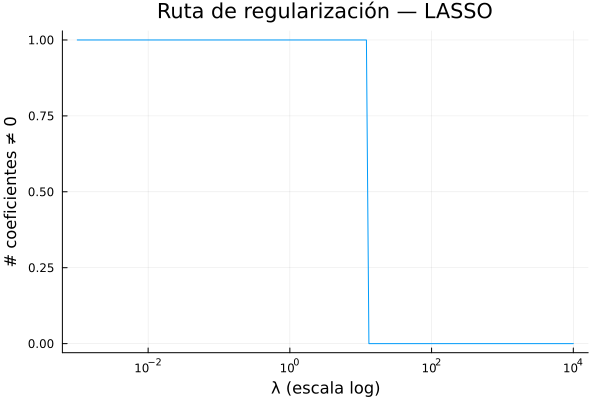

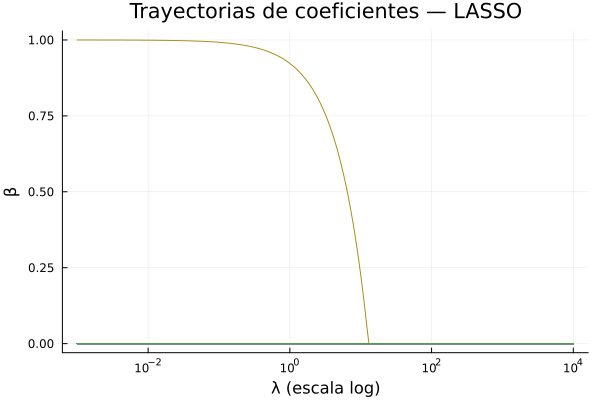

λ_max = 10000.0 | λ_min = 0.001 | #coef no-cero en λ_min: 1 de p = 275


In [45]:

# 1) Malla geométrica de λ (de 10^4 a 10^-3)
λ_grid = 10 .^ range(4, -3, length=200)

# 2) Ajuste del camino completo SOLO con train
Xtr = X[train_idx, :]
ytr = y[train_idx]
lasso_path = glmnet(Xtr, ytr, Normal(); alpha=1.0, lambda=λ_grid, standardize=true)

# 3) Conteo de coeficientes distintos de cero para cada λ
nz_count = [sum(abs.(lasso_path.betas[:, j]) .> 0.0) for j in eachindex(λ_grid)]

# 4) Gráfico de “sparsity” (#coef ≠ 0 vs λ)
p_sparse = plot(
    λ_grid, nz_count;
    xscale = :log10,
    xlabel = "λ (escala log)",
    ylabel = "# coeficientes ≠ 0",
    title  = "Ruta de regularización — LASSO",
    legend = false
)

# 5) Gráfico de trayectorias de coeficientes β(λ)
p_paths = plot(
    ; xscale = :log10,
    xlabel = "λ (escala log)",
    ylabel = "β",
    title  = "Trayectorias de coeficientes — LASSO",
    legend = false
)

for r in 1:size(lasso_path.betas, 1)
    plot!(p_paths, λ_grid, vec(lasso_path.betas[r, :]))
end

# Muestra en pantalla (o guarda con savefig)
display(p_sparse)
display(p_paths)

# (Opcional) resumen de extremos
println("λ_max = ", first(λ_grid), " | λ_min = ", last(λ_grid),
        " | #coef no-cero en λ_min: ", last(nz_count),
        " de p = ", size(X, 2))
